In [ ]:
########################################
# 0. 환경 설정 및 라이브러리 설치 (Colab)
########################################
# Google Drive 연동 (Colab 환경인 경우)
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 xgboost

########################################
# 라이브러리 Import 및 한글 폰트 설정
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


# Statsmodels & Prophet
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# TensorFlow / Keras & TCN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# XGBoost
from xgboost import XGBRegressor

# Optuna
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
라이브러리 임포트 및 한글 폰트 설정 완료!


In [ ]:
########################################
# 2. 데이터 로드 및 전처리
########################################
def load_data(data_path):
    """
    여러 인코딩 방식으로 CSV 파일을 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [ ]:

# 원본 변수 목록
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)',' 평균최고기온(℃)','평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)','최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

# Cases 차분 변수 추가
df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼 처리 및 정렬
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

In [ ]:

# 간단 EDA 출력
print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최다일강수량(mm)  평균풍속(m/s)  최대풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.2        1.5       12.5   
1  52.897434      2.1        7.8  ...         0.7        1.3        9.5   
2  21.600817      1.3        5.7  ...         0.7        2.3       13.1   
3  18.842018      0.1        6.3  ...         2.0        1.8       13.4   
4  11.594881     -3.6        1.0  ...        26.0        3.0       14.7   

   최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  Cases_Diff  
0      

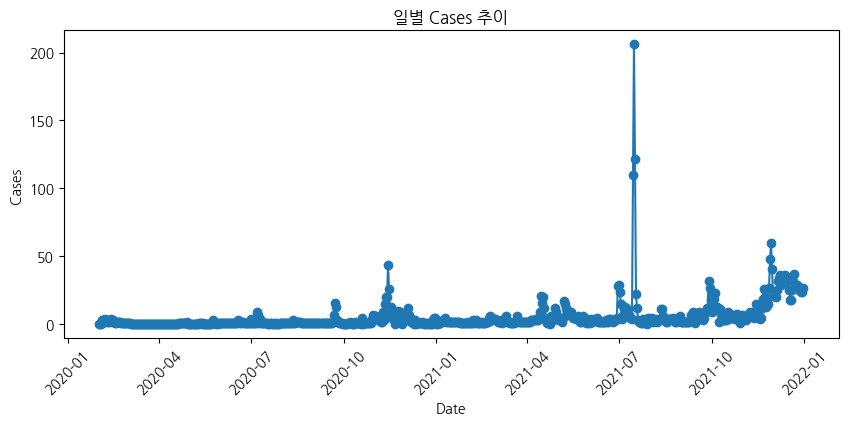

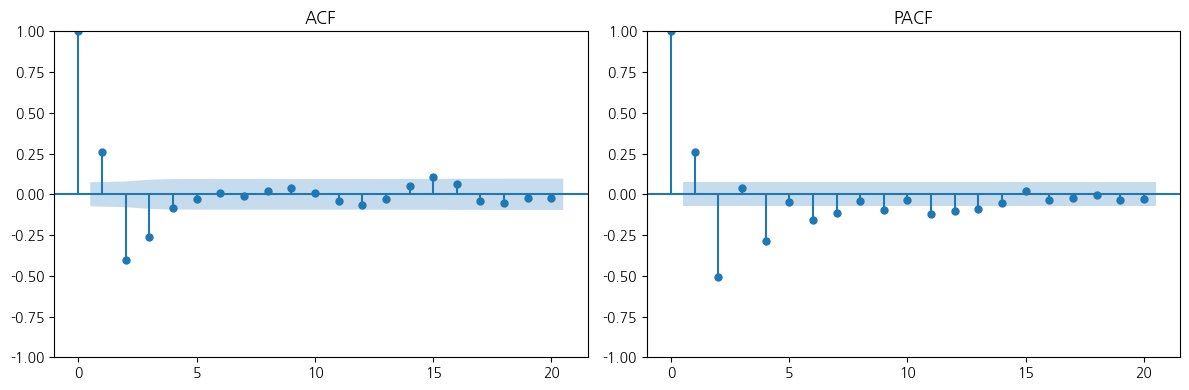

In [ ]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF 및 PACF 플롯
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [ ]:

########################################
# 4. Lag Feature 생성
########################################
def create_lag_features(dataframe, col_targets, lags):
    """
    col_targets에 대해 지정된 lags 만큼의 새로운 컬럼 생성.
    예: lags=(1,7,14) → 'col_target_lag1', 'col_target_lag7', 'col_target_lag14'
    """
    df_ = dataframe.copy()
    for col_target in col_targets:
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [ ]:

########################################
# 6. 시퀀스 데이터 생성 함수
########################################
def make_sequence_data(X_scaled, y_values, window):
    """
    window 길이만큼 슬라이딩 윈도우로 시퀀스 데이터를 생성합니다.
    X_seq: [샘플 수, window, feature 수]
    y_seq: window 이후의 target 값
    """
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window):
        X_seq.append(X_scaled[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
########################################
# 7. 모델 성능 평가 함수
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}")
    return {'model': model_name, 'MAE': mae_value, 'RMSE': rmse_value, 'MAPE': mape_value}

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.893
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           2.62e-13
Time:                        06:15:58   Log-Likelihood:                -2649.8
No. Observations:                 686   AIC:                             5338.
Df Residuals:                     667   BIC:                             5424.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          25.6499     12.665      2.025      

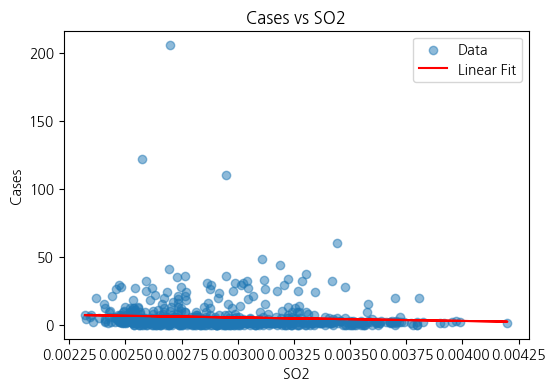

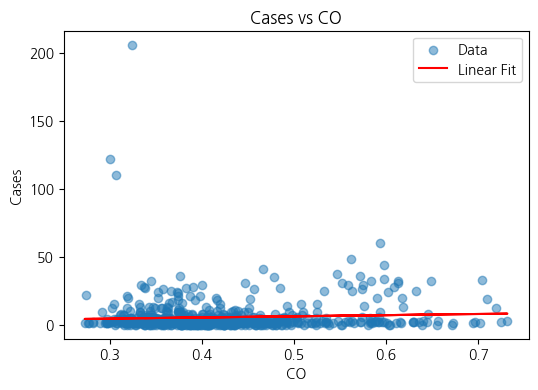

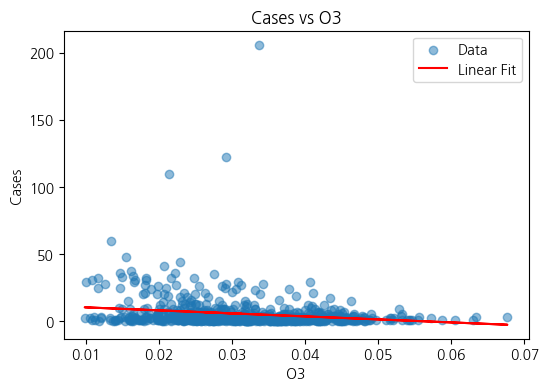

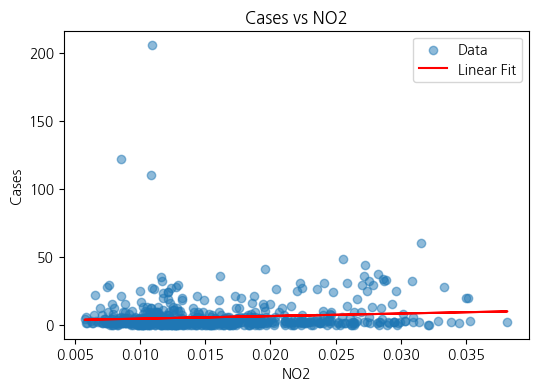

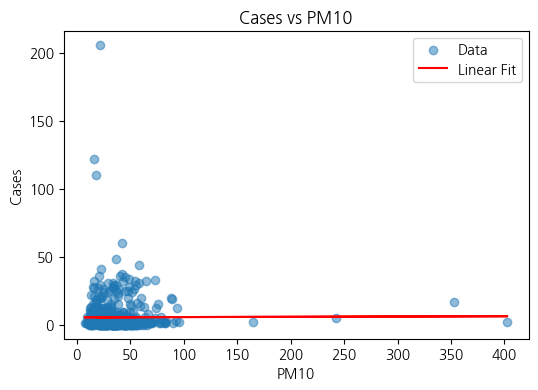

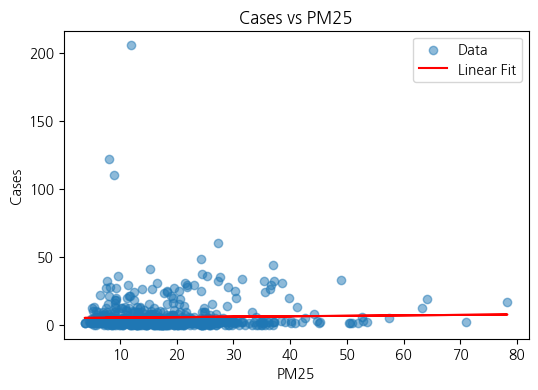

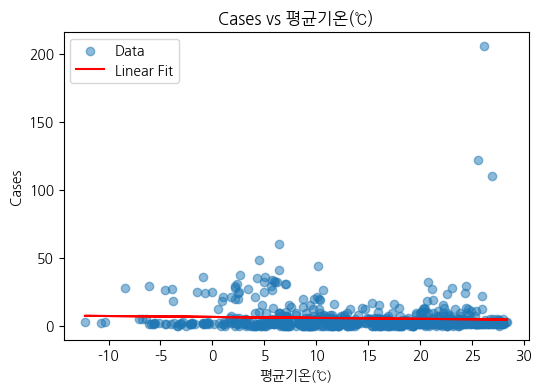

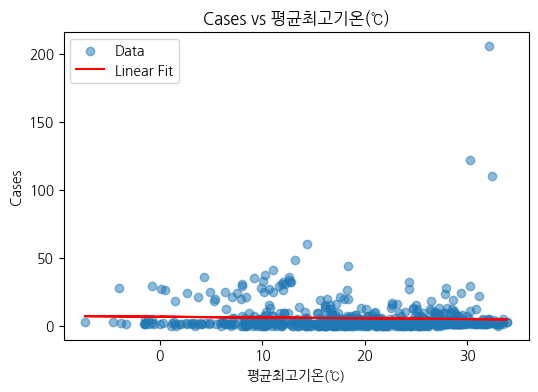

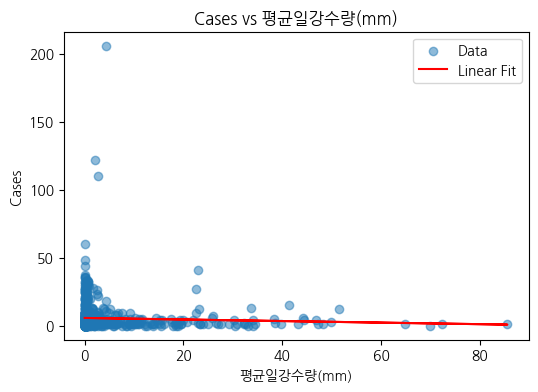

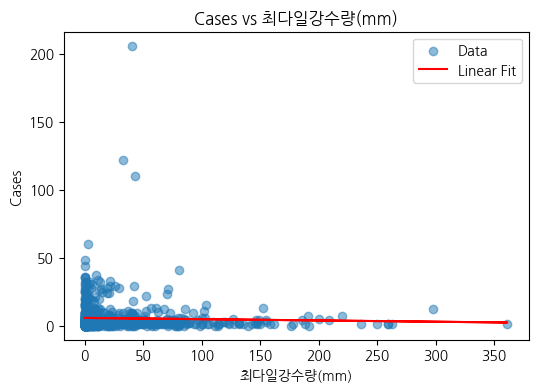

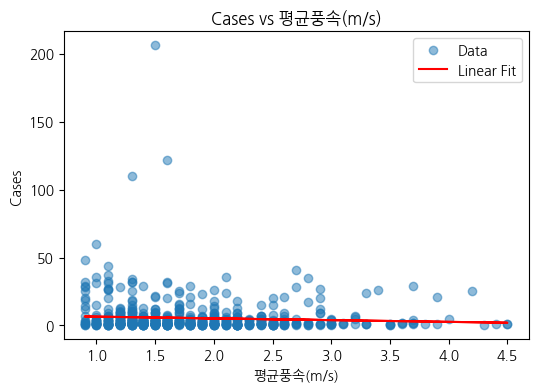

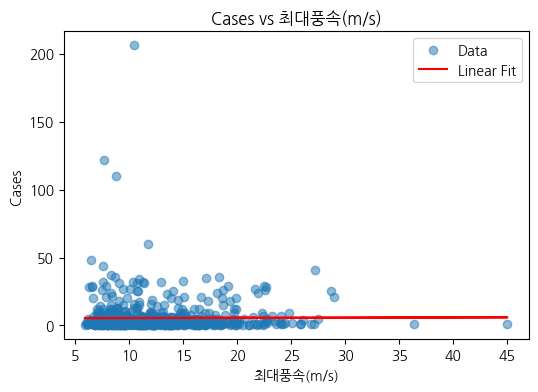

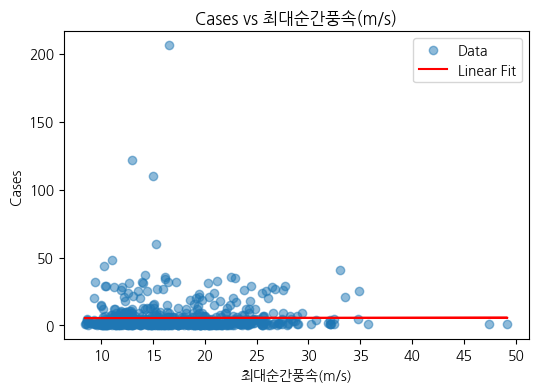

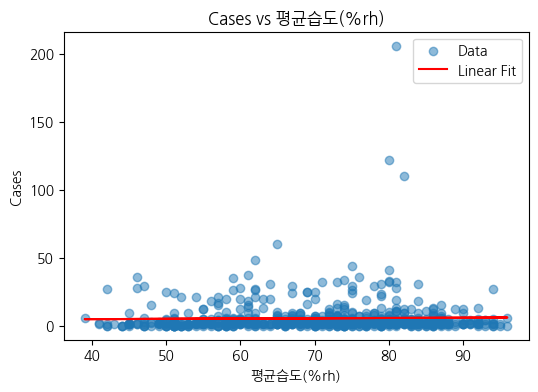

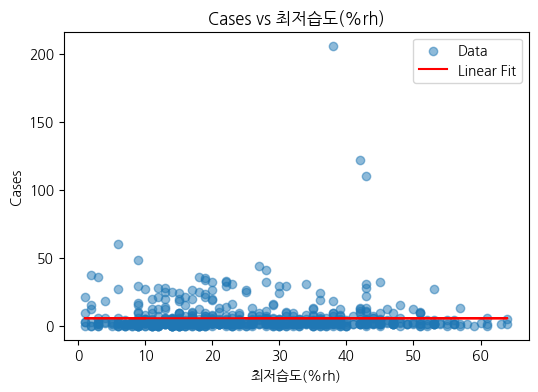

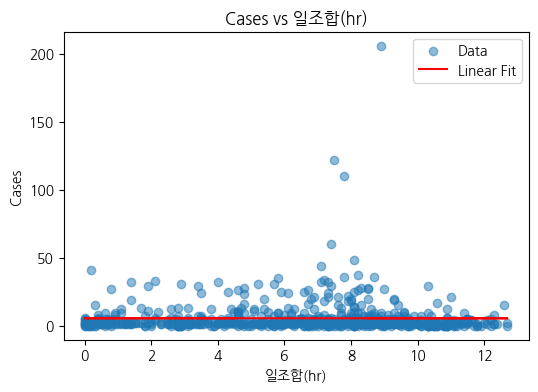

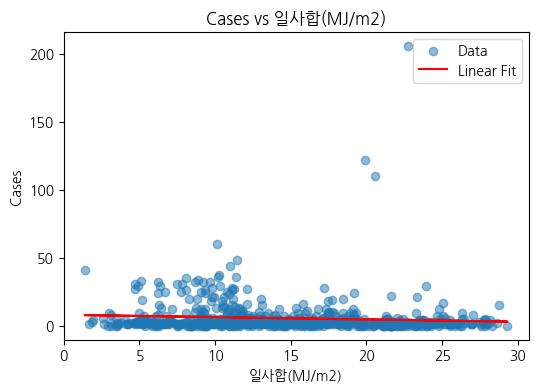

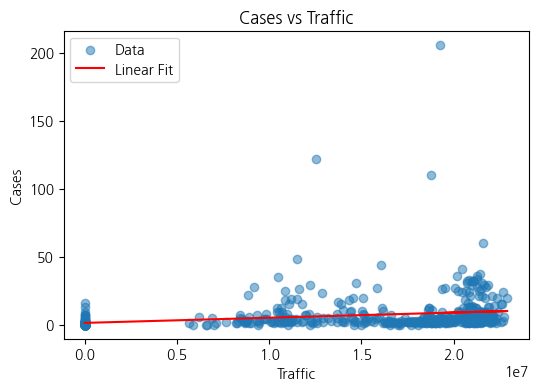

Ramsey RESET test F-statistic: 14.730691255767296
p-value: 0.00013582152931266428


In [ ]:
from statsmodels.stats.diagnostic import linear_reset
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균최고기온(℃)','평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)','최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']
X = df[original]
y = df['Cases']

# 상수항 추가 (모델 절편을 위해)
X = sm.add_constant(X)

# 선형 회귀 모델 적합
model = sm.OLS(y, X).fit()
print(model.summary())

# 각 독립변수와 종속변수의 관계를 산점도와 회귀선을 통해 시각적으로 확인
for col in X.columns:
    if col == 'const':  # 상수항은 제외
        continue
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], y, alpha=0.5, label='Data')
    # 해당 변수에 대해 1차 회귀선 계산
    slope, intercept = np.polyfit(df[col], y, 1)
    plt.plot(df[col], slope * df[col] + intercept, color='red', label='Linear Fit')
    plt.xlabel(col)
    plt.ylabel('Cases')
    plt.title(f'Cases vs {col}')
    plt.legend()
    plt.show()

# Ramsey RESET 테스트를 통해 선형모델의 적합성(선형성 가정 검증)
# power=2: 2차항을 포함하여 검증 / use_f=True: F-통계량 사용
reset_test = linear_reset(model, power=2, use_f=True)
f_statistic = reset_test.fvalue  # F-statistic 값 가져오기
p_value = reset_test.pvalue    # p-value 값 가져오기
print("Ramsey RESET test F-statistic:", f_statistic)
print("p-value:", p_value)

# 해석:
# - p-value가 0.05보다 작다면, 선형 모델의 가정이 위배될 가능성이 있으므로 비선형 모델을 고려해야 합니다.
# - p-value가 크다면, 선형 모델 가정 하에 충분히 설명 가능한 것으로 볼 수 있습니다.

In [ ]:
# feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']
feature_cols = df.columns.difference(['Date', 'Cases'])

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준, SARIMAX)
########################################
#  2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 106) 테스트세트 크기: (153, 106)


In [ ]:
########################################
# 데이터 스케일링
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y는 스케일링 안함
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
########################################
# SARIMAX
########################################

feature_cols = ['SO2','CO','O3','NO2','O3_lag8','PM25','Traffic','Cases_lag1']

def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  533
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1750.368
Date:                           Mon, 17 Feb 2025   AIC                           3524.736
Time:                                   06:17:24   BIC                           3575.874
Sample:                                        0   HQIC                          3544.762
                                           - 533                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2         1740.5430   1.98e-06   8.78e+08      0.000    1740.543    1740.543
CO           -10.6

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
########################################
# 5. Train/Validation/Test 분리 및 스케일링
########################################
feature_cols = ['SO2','CO','O3','NO2','O3','PM25','평균기온(℃)','평균일강수량(mm)','평균풍속(m/s)','평균습도(%rh)','일조합(hr)','Traffic','Cases_Diff']

# 날짜 기준 분할 (Validation < Test)
split_date_test = pd.to_datetime('2021-07-31')
split_date_val = pd.to_datetime('2021-05-31')

train_df = df[df['Date'] <= split_date_val].copy()
val_df = df[(df['Date'] > split_date_val) & (df['Date'] <= split_date_test)].copy()
test_df = df[df['Date'] > split_date_test].copy()
print(f"Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# 타깃 변수 (Cases)
y_train = train_df['Cases']
y_val   = val_df['Cases']
y_test  = test_df['Cases']

# 독립변수 (Feature)
X_train = train_df[feature_cols].dropna()
X_val   = val_df[feature_cols].dropna()
X_test  = test_df[feature_cols].dropna()

# Feature 스케일링 (y는 스케일링하지 않음)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled   = y_val.values
y_test_scaled  = y_test.values

Train=(472, 108), Validation=(61, 108), Test=(153, 108)


In [ ]:
########################################
# 모델 빌드 함수 (다층 구성 지원)
########################################
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(LSTM(lstm_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(GRU(gru_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(GRU(gru_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_cnn_model(input_shape, conv_filters, kernel_size, dropout_rate, optimizer_choice, learning_rate, num_layers=1):
    model = Sequential()
    # 첫 번째 Conv1D 레이어
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape, padding='same'))
    # 추가 Conv1D 및 Dropout 레이어
    for i in range(1, num_layers):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Dropout(dropout_rate))
    # 시간 축을 1차원으로 flatten
    model.add(Flatten())
    # 최종 출력층
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model


In [ ]:

########################################
# Optuna Objective Functions (Time Step 및 num_layers 튜닝)
########################################

In [ ]:
def objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10  # 빠른 튜닝을 위한 epoch 수 축소

    model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    rnn_units = trial.suggest_int("rnn_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=rnn_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    conv_filters = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 5

    model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=conv_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        optimizer_choice=optimizer_choice,
        learning_rate=learning_rate,
        num_layers=num_layers
    )

    cv_mapes = []
    from sklearn.model_selection import TimeSeriesSplit
    tscv_ = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv_.split(X_train_seq):
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]
        model_cv = clone_model(model)
        model_cv.set_weights(model.get_weights())
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_choice),
                           loss=tf.keras.losses.MeanAbsolutePercentageError(),
                           metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()])
        hist = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            shuffle=False
        )
        cv_mapes.append(hist.history['val_mean_absolute_percentage_error'][-1])
    return np.mean(cv_mapes)

In [ ]:
########################################
# Time Step 및 Hyperparameter 튜닝 실행 (Validation Set 사용)
########################################
timesteps_candidates = range(5,14)
dl_results_timestep_tuning = []

for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 데이터 준비: Feature/Target 분리 및 스케일링 (Validation set 포함)
    X_train_sub = train_df[feature_cols].dropna()
    X_val_sub   = val_df[feature_cols].dropna()
    X_test_sub  = test_df[feature_cols].dropna()

    X_train_scaled_sub = scaler_X.fit_transform(X_train_sub)
    X_val_scaled_sub   = scaler_X.transform(X_val_sub)
    X_test_scaled_sub  = scaler_X.transform(X_test_sub)

    # y index 정렬
    y_train_aligned = y_train.loc[X_train_sub.index]
    y_val_aligned   = y_val.loc[X_val_sub.index]
    y_test_aligned  = y_test.loc[X_test_sub.index]

    # 시퀀스 데이터 생성
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    ########################################
    # LSTM 튜닝 및 평가
    ########################################
    study_lstm = optuna.create_study(direction='minimize')
    objective_lstm = lambda trial: objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_lstm.optimize(objective_lstm, n_trials=10)
    best_params_lstm = study_lstm.best_trial.params
    lstm_model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=best_params_lstm['lstm_units'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        num_layers=best_params_lstm['num_layers']
    )
    epochs_best = 20
    lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                   epochs=epochs_best, batch_size=best_params_lstm['batch_size'], verbose=0)
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    lstm_result = evaluate_performance(y_test_seq, lstm_pred, model_name="LSTM")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'LSTM', 'Best Params': best_params_lstm, **lstm_result})

    ########################################
    # GRU 튜닝 및 평가
    ########################################
    study_gru = optuna.create_study(direction='minimize')
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_gru.optimize(objective_gru, n_trials=10)
    best_params_gru = study_gru.best_trial.params
    gru_model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=best_params_gru['gru_units'],
        dropout_rate=best_params_gru['dropout_rate'],
        learning_rate=best_params_gru['learning_rate'],
        num_layers=best_params_gru['num_layers']
    )
    gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_gru['batch_size'], verbose=0)
    gru_pred = gru_model.predict(X_test_seq).flatten()
    gru_result = evaluate_performance(y_test_seq, gru_pred, model_name="GRU")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'GRU', 'Best Params': best_params_gru, **gru_result})

    ########################################
    # RNN 튜닝 및 평가
    ########################################
    study_rnn = optuna.create_study(direction='minimize')
    objective_rnn = lambda trial: objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_rnn.optimize(objective_rnn, n_trials=10)
    best_params_rnn = study_rnn.best_trial.params
    rnn_model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=best_params_rnn['rnn_units'],
        dropout_rate=best_params_rnn['dropout_rate'],
        learning_rate=best_params_rnn['learning_rate'],
        num_layers=best_params_rnn['num_layers']
    )
    rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_rnn['batch_size'], verbose=0)
    rnn_pred = rnn_model.predict(X_test_seq).flatten()
    rnn_result = evaluate_performance(y_test_seq, rnn_pred, model_name="RNN")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'RNN', 'Best Params': best_params_rnn, **rnn_result})

    ########################################
    # CNN 튜닝 및 평가
    ########################################
    study_cnn = optuna.create_study(direction='minimize')
    objective_cnn = lambda trial: objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_cnn.optimize(objective_cnn, n_trials=10)
    best_params_cnn = study_cnn.best_trial.params
    cnn_model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=best_params_cnn['conv_filters'],
        kernel_size=best_params_cnn['kernel_size'],
        dropout_rate=best_params_cnn['dropout_rate'],
        optimizer_choice=best_params_cnn['optimizer_choice'],
        learning_rate=best_params_cnn['learning_rate'],
        num_layers=best_params_cnn['num_layers']
    )
    cnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_cnn['batch_size'], verbose=0)
    cnn_pred = cnn_model.predict(X_test_seq).flatten()
    cnn_result = evaluate_performance(y_test_seq, cnn_pred, model_name="CNN")

    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'CNN', 'Best Params': best_params_cnn, **cnn_result})

[I 2025-02-17 07:40:54,378] A new study created in memory with name: no-name-d0f9686e-574f-4bdc-bef3-60d6a6d119f1



===== Time Steps: 20 =====


<ipython-input-73-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 07:41:13,758] Trial 0 finished with value: 26001.75 and parameters: {'lstm_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.00014868414573550616, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 26001.75.
[I 2025-02-17 07:41:23,196] Trial 1 finished with value: 176958.84375 and parameters: {'lstm_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.00012198546585301505, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 26001.75.
[I 2025-02-17 07:41:52,214] Trial 2 finished with value: 18591.197265625 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0013493366450633949, 'batch_size': 16, 'num_layers': 3}. Bes

5/5 [==============================] - 1s 6ms/step


[I 2025-02-17 07:44:03,342] A new study created in memory with name: no-name-c1f9010d-b391-422b-aa7a-77608d2ee371


[LSTM] MAE=13.379, RMSE=17.803, MAPE=0.996


<ipython-input-74-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 07:44:28,690] Trial 0 finished with value: 16022.958984375 and parameters: {'gru_units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.0002183712985458727, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 16022.958984375.
[I 2025-02-17 07:44:49,772] Trial 1 finished with value: 146314.109375 and parameters: {'gru_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005943783351073464, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 16022.958984375.
[I 2025-02-17 07:44:58,659] Trial 2 finished with value: 193825.453125 and parameters: {'gru_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00376169114906

5/5 [==============================] - 2s 30ms/step


[I 2025-02-17 07:47:59,569] A new study created in memory with name: no-name-43161fa6-0cfa-43a8-9ec4-f3d2bc5fc2db


[GRU] MAE=13.379, RMSE=17.804, MAPE=0.996


<ipython-input-75-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 07:48:25,059] Trial 0 finished with value: 932963.125 and parameters: {'rnn_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.00011383720943351998, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 932963.125.
[I 2025-02-17 07:48:32,973] Trial 1 finished with value: 12099922.0 and parameters: {'rnn_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.007018553030579691, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 932963.125.
[I 2025-02-17 07:48:37,555] Trial 2 finished with value: 2302245.25 and parameters: {'rnn_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.0006891116135535186, 'batch_size': 32, 'num_layer

5/5 [==============================] - 0s 4ms/step


[I 2025-02-17 07:49:58,822] A new study created in memory with name: no-name-d9cb1e20-c2e3-4d46-907d-8875f6cfb9a5


[RNN] MAE=13.375, RMSE=17.787, MAPE=0.999


[I 2025-02-17 07:50:03,310] Trial 0 finished with value: 400075108909056.0 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.0, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.00017733569834212188, 'num_layers': 1}. Best is trial 0 with value: 400075108909056.0.
[I 2025-02-17 07:50:08,609] Trial 1 finished with value: 4943830.447916667 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.006177441611691126, 'num_layers': 1}. Best is trial 1 with value: 4943830.447916667.
[I 2025-02-17 07:50:12,368] Trial 2 finished with value: 346608214474752.0 and parameters: {'conv_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0008263740549243351, 'num_layers': 1}. Best is trial 1 with value: 4943830.447916667.
[I 2025-02-17 07:50:16,259] Trial 3 finished with value: 400073302562133.3 and parameters: {'

5/5 [==============================] - 0s 4ms/step


[I 2025-02-17 07:51:03,606] A new study created in memory with name: no-name-7dbd2641-7b8d-4f2d-9553-0e5520a2718a


[CNN] MAE=13.397, RMSE=17.815, MAPE=1.000

===== Time Steps: 30 =====


<ipython-input-73-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 07:51:13,417] Trial 0 finished with value: 113911.5546875 and parameters: {'lstm_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0003652164604326496, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 113911.5546875.
[I 2025-02-17 07:51:59,817] Trial 1 finished with value: 179586.8125 and parameters: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0033965147606054985, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 113911.5546875.
[I 2025-02-17 07:52:48,393] Trial 2 finished with value: 6156.5908203125 and parameters: {'lstm_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate':

4/4 [==============================] - 3s 134ms/step


[I 2025-02-17 07:56:29,269] A new study created in memory with name: no-name-a9e209ea-035c-4d2d-ac35-dca904d05123


[LSTM] MAE=14.197, RMSE=18.498, MAPE=1.000


<ipython-input-74-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 07:56:37,574] Trial 0 finished with value: 124820.703125 and parameters: {'gru_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.0003183864696462846, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 124820.703125.
[W 2025-02-17 07:56:46,775] Trial 1 failed with parameters: {'gru_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0014102248033248954, 'batch_size': 32, 'num_layers': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipy

KeyboardInterrupt: 

In [ ]:
########################################
# 11. 최종 결과 비교 (딥러닝 모델 및 기존 ML 모델)
# timestep 5-14일을 돌린 결과 유의미한 결를 찾을 수 없었음.
########################################
dl_results_df = pd.DataFrame(dl_results_timestep_tuning)
print("\n=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===")
display(dl_results_df)

# 각 모델별 Best Time Steps (MAPE 기준) 출력
best_lstm_row = dl_results_df[dl_results_df['Model'] == 'LSTM'].sort_values(by='MAPE').iloc[0]
best_gru_row  = dl_results_df[dl_results_df['Model'] == 'GRU'].sort_values(by='MAPE').iloc[0]
best_rnn_row  = dl_results_df[dl_results_df['Model'] == 'RNN'].sort_values(by='MAPE').iloc[0]
best_cnn_row  = dl_results_df[dl_results_df['Model'] == 'CNN'].sort_values(by='MAPE').iloc[0]

print("\n=== 각 모델별 Best Time Steps (MAPE 기준) ===")
print(f"[LSTM] Best Time Steps: {best_lstm_row['Time Steps']}, MAPE: {best_lstm_row['MAPE']:.3f}, Hyperparams: {best_lstm_row['Best Params']}")
print(f"[GRU]  Best Time Steps: {best_gru_row['Time Steps']}, MAPE: {best_gru_row['MAPE']:.3f}, Hyperparams: {best_gru_row['Best Params']}")
print(f"[RNN]  Best Time Steps: {best_rnn_row['Time Steps']}, MAPE: {best_rnn_row['MAPE']:.3f}, Hyperparams: {best_rnn_row['Best Params']}")
print(f"[CNN]  Best Time Steps: {best_cnn_row['Time Steps']}, MAPE: {best_cnn_row['MAPE']:.3f}, Hyperparams: {best_cnn_row['Best Params']}")

In [ ]:
feature_cols = df.columns.difference(['Date', 'Cases'])

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 106) 테스트세트 크기: (153, 106)


In [ ]:
########################################
# 데이터 스케일링
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# X_train_scaled, y_train_scaled는 이미 스케일링된 train 데이터입니다.
# 예를 들어, 이전 코드에서 X_train_scaled = scaler_X.fit_transform(X_train) 등으로 생성
# feature_cols = df.columns.difference(['Date', 'Cases'])
########################################
# 1. SVR 하이퍼파라미터 최적화
########################################
def objective_svr(trial):
    # 주요 파라미터: kernel, gamma, C, epsilon
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    else:
        gamma = 'scale'
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)

    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_trial.params
print("Best SVR parameters:", best_params_svr)

########################################
# 2. Random Forest (RF) 하이퍼파라미터 최적화
########################################
def objective_rf(trial):
    # 주요 파라미터: n_estimators, criterion, min_samples_split, min_samples_leaf, max_features
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
best_params_rf = study_rf.best_trial.params
print("Best RF parameters:", best_params_rf)


[I 2025-02-17 06:18:05,851] A new study created in memory with name: no-name-1a28e638-3410-4226-9253-130272cfd387
<ipython-input-49-c2d0b046e5f9>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
<ipython-input-49-c2d0b046e5f9>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-49-c2d0b046e5f9>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)


Best SVR parameters: {'kernel': 'poly', 'gamma': 0.0003178481531114941, 'C': 0.2392678832004247, 'epsilon': 0.010008799345503548}


[I 2025-02-17 06:18:19,426] Trial 0 finished with value: 538803424035551.25 and parameters: {'n_estimators': 200, 'criterion': 'squared_error', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 538803424035551.25.
[I 2025-02-17 06:18:20,604] Trial 1 finished with value: 497572312546140.0 and parameters: {'n_estimators': 150, 'criterion': 'squared_error', 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 497572312546140.0.
[I 2025-02-17 06:18:21,211] Trial 2 finished with value: 476804178153842.56 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 476804178153842.56.
[I 2025-02-17 06:18:34,259] Trial 3 finished with value: 333015791047849.25 and parameters: {'n_estimators': 300, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': Non

Best RF parameters: {'n_estimators': 50, 'criterion': 'squared_error', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [ ]:
def objective_xgb(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
    base_score = trial.suggest_float('base_score', 0.1, 0.5)

    # booster가 gbtree 또는 dart일 때만 적용할 파라미터
    if booster in ['gbtree', 'dart']:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        sampling_method = 'uniform'  # GPU 사용 안할 경우 고정값
        tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            sampling_method=sampling_method,
            tree_method=tree_method,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )
    else:  # booster가 gblinear인 경우
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )

    tscv = TimeSeriesSplit(n_splits=3)
    mape_scores = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_cv_train, y_cv_val = y_train_scaled.iloc[train_index], y_train_scaled.iloc[val_index]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        mape = mean_absolute_percentage_error(y_cv_val, y_pred)
        mape_scores.append(mape)
    return np.mean(mape_scores)



study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

best_params_xgb = study_xgb.best_trial.params
print("Best XGBoost parameters:", best_params_xgb)

########################################
# 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_model_opt = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_model_opt.fit(X_train_scaled, y_train_scaled)
svr_pred_opt = svr_model_opt.predict(X_test_scaled)
svr_result_opt = evaluate_performance(y_test, svr_pred_opt, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_model_opt = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model_opt.fit(X_train_scaled, y_train_scaled)
rf_pred_opt = rf_model_opt.predict(X_test_scaled)
rf_result_opt = evaluate_performance(y_test, rf_pred_opt, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_model_opt = XGBRegressor(
    booster=best_params_xgb['booster'],
    learning_rate=best_params_xgb['eta'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    sampling_method='uniform',  # 여기서 고정값 사용
    tree_method=best_params_xgb['tree_method'],
    base_score=best_params_xgb['base_score'],
    n_estimators=200,
    random_state=42
)

xgb_model_opt.fit(X_train_scaled, y_train_scaled)
xgb_pred_opt = xgb_model_opt.predict(X_test_scaled)
xgb_result_opt = evaluate_performance(y_test, xgb_pred_opt, model_name="XGBoost_Optuna")


[I 2025-02-17 06:27:10,774] A new study created in memory with name: no-name-aa903952-d2ad-4f01-a97f-307015061cc1
[I 2025-02-17 06:27:12,098] Trial 0 finished with value: 258392807440384.0 and parameters: {'booster': 'gbtree', 'eta': 0.060000000000000005, 'base_score': 0.16047267350037386, 'max_depth': 3, 'min_child_weight': 3, 'tree_method': 'auto'}. Best is trial 0 with value: 258392807440384.0.
[I 2025-02-17 06:27:51,202] Trial 1 finished with value: 161735464626858.66 and parameters: {'booster': 'dart', 'eta': 0.01, 'base_score': 0.4444380662771408, 'max_depth': 7, 'min_child_weight': 2, 'tree_method': 'hist'}. Best is trial 1 with value: 161735464626858.66.
[I 2025-02-17 06:27:52,893] Trial 2 finished with value: 274184789819392.0 and parameters: {'booster': 'gbtree', 'eta': 0.01, 'base_score': 0.22532974742626008, 'max_depth': 4, 'min_child_weight': 4, 'tree_method': 'auto'}. Best is trial 1 with value: 161735464626858.66.
[I 2025-02-17 06:27:53,091] Trial 3 finished with value: 

KeyboardInterrupt: 

In [ ]:
#### lag데이터를 안넣은 결과

In [ ]:
feature_cols = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균최고기온(℃)',
                '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
                '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)','일사합(MJ/m2)',
                'Traffic', 'Cases_lag1','Cases_Diff']

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 20) 테스트세트 크기: (153, 20)


In [ ]:
########################################
# 데이터 스케일링
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:

study_svr2 = optuna.create_study(direction='minimize')
study_svr2.optimize(objective_svr, n_trials=100)
best_params_svr2 = study_svr2.best_trial.params
print("Best SVR parameters:", best_params_svr2)


study_rf2 = optuna.create_study(direction='minimize')
study_rf2.optimize(objective_rf, n_trials=100)
best_params_rf2 = study_rf2.best_trial.params
print("Best RF parameters:", best_params_rf2)


[I 2025-02-17 06:55:50,927] A new study created in memory with name: no-name-ba82efca-6672-48e8-9523-a684e83949f0
<ipython-input-63-86adbab13011>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
<ipython-input-63-86adbab13011>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-63-86adbab13011>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)


Best SVR parameters: {'kernel': 'poly', 'gamma': 0.00010141645927163367, 'C': 2.9973784132953316, 'epsilon': 0.010017439017479639}


[I 2025-02-17 06:56:00,183] Trial 0 finished with value: 557768388353127.75 and parameters: {'n_estimators': 300, 'criterion': 'squared_error', 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 557768388353127.75.
[I 2025-02-17 06:56:00,742] Trial 1 finished with value: 508115170222038.8 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 508115170222038.8.
[I 2025-02-17 06:56:05,088] Trial 2 finished with value: 327047115797143.3 and parameters: {'n_estimators': 100, 'criterion': 'absolute_error', 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 327047115797143.3.
[I 2025-02-17 06:56:12,806] Trial 3 finished with value: 342284858897269.2 and parameters: {'n_estimators': 200, 'criterion': 'absolute_error', 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}.

Best RF parameters: {'n_estimators': 50, 'criterion': 'squared_error', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}


In [ ]:
study_xgb2 = optuna.create_study(direction='minimize')
study_xgb2.optimize(objective_xgb, n_trials=100)

best_params_xgb2 = study_xgb2.best_trial.params
print("Best XGBoost parameters:", best_params_xgb2)

########################################
# 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_opt2 = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_opt2.fit(X_train_scaled, y_train_scaled)
svr_pred2 = svr_opt2.predict(X_test_scaled)
svr_result_opt2 = evaluate_performance(y_test, svr_pred2, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_opt2 = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_opt2.fit(X_train_scaled, y_train_scaled)
rf_pred_2 = rf_opt2.predict(X_test_scaled)
rf_result_opt2 = evaluate_performance(y_test, rf_pred_2, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_opt2 = XGBRegressor(
    booster=best_params_xgb2['booster'],
    learning_rate=best_params_xgb2['eta'],
    max_depth=best_params_xgb2['max_depth'],
    min_child_weight=best_params_xgb2['min_child_weight'],
    sampling_method='uniform',  # 여기서 고정값 사용
    tree_method=best_params_xgb2['tree_method'],
    base_score=best_params_xgb2['base_score'],
    n_estimators=200,
    random_state=42
)

xgb_opt2.fit(X_train_scaled, y_train_scaled)
xgb_pred_2 = xgb_opt2.predict(X_test_scaled)
xgb_result_opt2 = evaluate_performance(y_test, xgb_pred_2, model_name="XGBoost_Optuna")


[I 2025-02-17 06:57:57,308] A new study created in memory with name: no-name-a257f4e7-d093-4e7f-b0a9-7fe6d4c09933
[I 2025-02-17 06:57:57,928] Trial 0 finished with value: 251392147761834.66 and parameters: {'booster': 'gbtree', 'eta': 0.14, 'base_score': 0.3567265615301466, 'max_depth': 7, 'min_child_weight': 9, 'tree_method': 'exact'}. Best is trial 0 with value: 251392147761834.66.
[I 2025-02-17 06:57:58,867] Trial 1 finished with value: 160407560563370.66 and parameters: {'booster': 'gbtree', 'eta': 0.15000000000000002, 'base_score': 0.3218169647154051, 'max_depth': 9, 'min_child_weight': 5, 'tree_method': 'hist'}. Best is trial 1 with value: 160407560563370.66.
[I 2025-02-17 06:57:58,944] Trial 2 finished with value: 553406144621226.7 and parameters: {'booster': 'gblinear', 'eta': 0.24000000000000002, 'base_score': 0.3167061914266426}. Best is trial 1 with value: 160407560563370.66.
[I 2025-02-17 06:58:01,929] Trial 3 finished with value: 291289639682048.0 and parameters: {'booster

Best XGBoost parameters: {'booster': 'gbtree', 'eta': 0.24000000000000002, 'base_score': 0.18565206000893225, 'max_depth': 8, 'min_child_weight': 1, 'tree_method': 'hist'}
[SVM(SVR)_Optuna] MAE=11.167, RMSE=15.979, MAPE=0.807
[RF_Optuna] MAE=3.322, RMSE=6.334, MAPE=0.188
[XGBoost_Optuna] MAE=3.036, RMSE=6.268, MAPE=0.155


In [ ]:
# X_train이 DataFrame 형태라고 가정하고, feature 이름을 추출합니다.
feature_names = X_train.columns

# Random Forest 모델의 feature importance를 DataFrame으로 정리
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_opt2.feature_importances_
})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_importance_df)

# XGBoost 모델의 feature importance를 DataFrame으로 정리
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_opt2.feature_importances_
})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
print("XGBoost Feature Importances:")
print(xgb_importance_df)

Random Forest Feature Importances:
        Feature  Importance
19   Cases_Diff    0.548986
18   Cases_lag1    0.388622
5          PM25    0.009239
12  최대순간풍속(m/s)    0.006196
4          PM10    0.006051
11    최대풍속(m/s)    0.005707
16   일사합(MJ/m2)    0.004849
17      Traffic    0.004650
0           SO2    0.004197
3           NO2    0.004017
7     평균최고기온(℃)    0.003278
10    평균풍속(m/s)    0.002410
13    평균습도(%rh)    0.002294
14    최저습도(%rh)    0.002046
8    평균일강수량(mm)    0.001777
15      일조합(hr)    0.001671
1            CO    0.001632
2            O3    0.001196
9    최다일강수량(mm)    0.000712
6       평균기온(℃)    0.000470
XGBoost Feature Importances:
        Feature  Importance
19   Cases_Diff    0.479336
18   Cases_lag1    0.405850
1            CO    0.103681
0           SO2    0.003931
11    최대풍속(m/s)    0.003817
6       평균기온(℃)    0.000937
12  최대순간풍속(m/s)    0.000626
13    평균습도(%rh)    0.000455
17      Traffic    0.000325
3           NO2    0.000208
5          PM25    0.000199
15      일조합(

In [ ]:
# Excel 파일로 저장 (openpyxl 패키지가 설치되어 있어야 함)
excel_filename = "feature_importances.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    rf_importance_df.to_excel(writer, sheet_name="Random Forest", index=False)
    xgb_importance_df.to_excel(writer, sheet_name="XGBoost", index=False)

print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")

엑셀 파일 'feature_importances.xlsx'가 저장되었습니다.


In [ ]:

from sklearn.inspection import permutation_importance
results = permutation_importance(svr_model_opt, X_test_scaled, y_test_scaled, scoring='neg_mean_squared_error')

# Feature 중요도를 DataFrame으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("SVR Feature Importances:")
print(feature_importance_df)
excel_filename = "feature_importances_SVR.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    feature_importance_df.to_excel(writer, sheet_name="SVR", index=False)


print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")


SVR Feature Importances:
         Feature    Importance
16           NO2  2.841829e-07
0             CO  1.497689e-07
46     PM25_lag8  1.287412e-07
47     PM25_lag9  1.247825e-07
35    PM25_lag10  9.387488e-08
..           ...           ...
58       평균기온(℃) -4.066007e-07
68  평균기온(℃)_lag5 -4.079514e-07
69  평균기온(℃)_lag6 -4.112031e-07
71  평균기온(℃)_lag8 -4.191639e-07
70  평균기온(℃)_lag7 -4.238406e-07

[106 rows x 2 columns]
엑셀 파일 'feature_importances_SVR.xlsx'가 저장되었습니다.


In [79]:
# def train_prophet(train_df_, test_df_, extra_regressors):
#     prophet_model = Prophet(
#         growth='linear',
#         yearly_seasonality=True,
#         weekly_seasonality=True,
#         daily_seasonality=False,
#         seasonality_mode='additive',
#         changepoint_prior_scale=0.05  # 추세 민감도 감소
#     )
#     # 추가 사용자 정의 계절성 (예: 7일 주기)
#     prophet_model.add_seasonality(name='weekly_custom', period=14
#                                   , fourier_order=3)

#     for col in extra_regressors:
#         prophet_model.add_regressor(col)
#     prophet_model.fit(train_df_)

#     # 테스트 기간 예측 시, 잠복기간 효과를 반영해 예측 기간을 늘릴 수 있음.
#     # 여기서는 기존 테스트 기간을 그대로 사용
#     future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
#     for col in extra_regressors:
#         future[col] = test_df_[col].values
#     forecast = prophet_model.predict(future)
#     return prophet_model, forecast

# # 데이터 준비: 예를 들어, 7일 지연 변수 추가
# prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases']})
# prophet_test  = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases']})

# # 기존 feature_cols에 lag 변수 추가
# # feature_cols = df.columns.difference(['Date', 'Cases'])
# original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균최고기온(℃)',
#             '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
#             '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)',
#             '일사합(MJ/m2)','Traffic']
# feature_cols = ['SO2','CO','O3','NO2','평균최고기온(℃)','최대순간풍속(m/s)','PM10','일조합(hr)','PM25_lag5','Traffic','Cases_lag1']
# for col in feature_cols:
#     prophet_train[col] = train_df[col].values
#     prophet_test[col]  = test_df[col].values

# prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
# prophet_pred = prophet_forecast['yhat'].values
# prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1p5itgc_/7ktxusvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1p5itgc_/age9xjpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70851', 'data', 'file=/tmp/tmp1p5itgc_/7ktxusvu.json', 'init=/tmp/tmp1p5itgc_/age9xjpn.json', 'output', 'file=/tmp/tmp1p5itgc_/prophet_model4ux58oq9/prophet_model-20250217084155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=4.290, RMSE=6.614, MAPE=0.472


In [80]:
def train_prophet(train_df_, test_df_, extra_regressors):
    # 상한 값 설정 (예: 데이터의 최대값을 참고하여 설정)
    cap_value = train_df_['y'].max() * 1.2  # 최대값보다 20% 더 높게 설정
    train_df_['cap'] = cap_value
    test_df_['cap'] = cap_value

    prophet_model = Prophet(
        growth='logistic',  # 선형이 아닌 로지스틱 성장 적용
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.1  # 변곡점 민감도를 조금 높임
    )

    # 추가 사용자 정의 계절성 (예: 7일 주기)
    prophet_model.add_seasonality(name='weekly_custom', period=14, fourier_order=3)

    for col in extra_regressors:
        prophet_model.add_regressor(col)

    prophet_model.fit(train_df_)

    # 테스트 데이터 처리
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values
    future['cap'] = cap_value  # 상한값 적용

    forecast = prophet_model.predict(future)
    return prophet_model, forecast

# 데이터 준비: logistic 성장 모델 적용을 위해 'cap' 추가
cap_value = train_df['Cases'].max() * 1.2  # 데이터의 최대값보다 20% 높은 상한 설정
prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases'], 'cap': cap_value})
prophet_test = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases'], 'cap': cap_value})

feature_cols = ['SO2','CO','O3','NO2','평균최고기온(℃)','최대순간풍속(m/s)','PM10','일조합(hr)','PM25_lag5','Traffic','Cases_lag1']
# 기존 feature_cols에 lag 변수 추가
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col]  = test_df[col].values

prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1p5itgc_/a6exkjoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1p5itgc_/1j6_g4zn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99725', 'data', 'file=/tmp/tmp1p5itgc_/a6exkjoc.json', 'init=/tmp/tmp1p5itgc_/1j6_g4zn.json', 'output', 'file=/tmp/tmp1p5itgc_/prophet_model9zh0evli/prophet_model-20250217084417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=4.448, RMSE=6.671, MAPE=0.512



=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===


<ipython-input-33-029a13947efb>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_results_df_window.fillna('-', inplace=True)


,Model,Time Steps,Best Params,MAE,RMSE,MAPE
0,LSTM(BestWindow),14.0,"{'lstm_units': 256, 'dropout_rate': 0.30000000...",12.944180,17.436580,0.998809
1,GRU(BestWindow),8.0,"{'gru_units': 96, 'dropout_rate': 0.1, 'learni...",12.670274,17.129928,0.997693
2,RNN,14.0,"{'rnn_units': 32, 'dropout_rate': 0.1, 'learni...",12.858643,17.367783,0.982889
3,CNN(BestWindow),12.0,"{'conv_filters': 64, 'kernel_size': 3, 'dropou...",12.876543,17.338147,0.998573
4,SARIMAX,-,-,3.855252,5.888161,0.467871
5,SVM(SVR)_Optuna,-,-,11.166722,15.978700,0.806900
6,RF_Optuna,-,-,2.637053,4.804999,0.195654
7,XGBoost_Optuna,-,-,5.445498,9.683254,0.287657
8,Prophet,-,-,4.524425,6.630325,0.565131


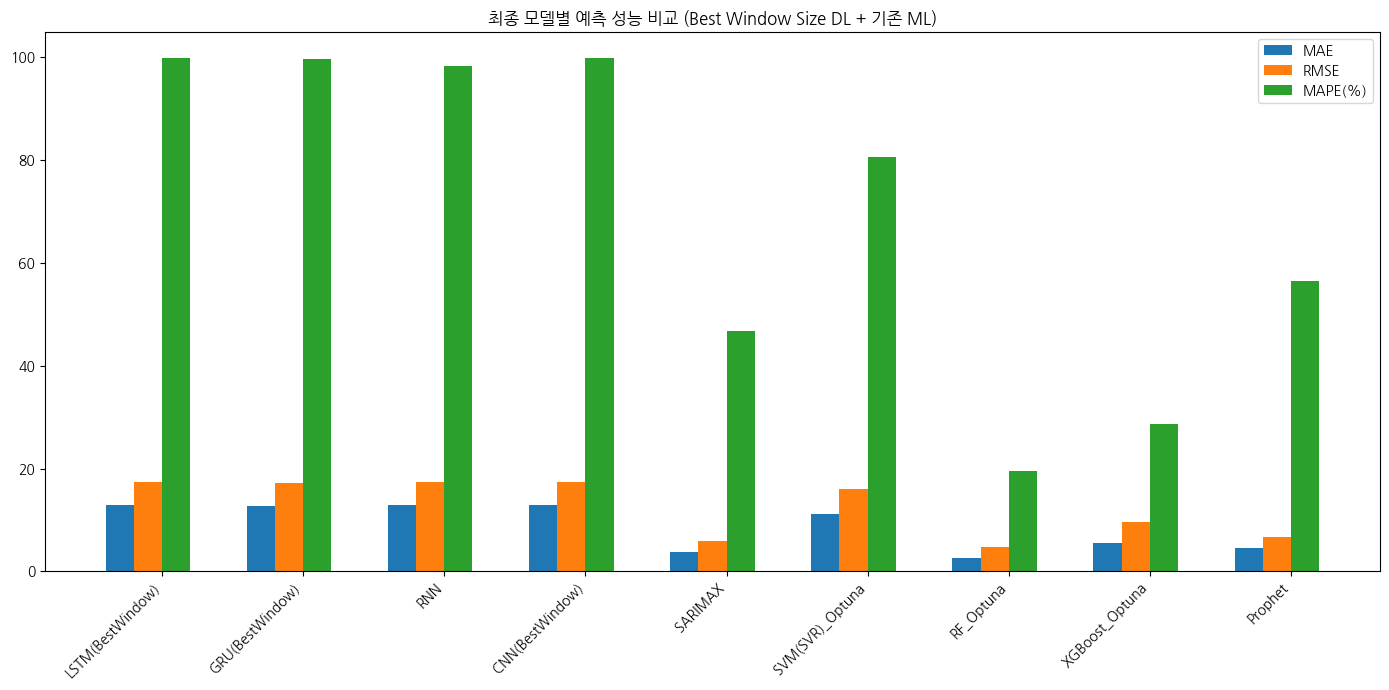


작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.


In [ ]:
########################################
# 12. 최종 결과 비교 및 시각화
########################################
# 모델 이름 수정 (Best Window Size DL 모델)
best_lstm_row['Model'] = 'LSTM(BestWindow)'
best_gru_row['Model'] = 'GRU(BestWindow)'
best_cnn_row['Model'] = 'CNN(BestWindow)'
sarimax_result['Model'] = 'SARIMAX'
svr_result_opt['Model'] = 'SVM(SVR)_Optuna'
rf_result_opt['Model'] = 'RF_Optuna'
xgb_result_opt['Model'] = 'XGBoost_Optuna'
prophet_result['Model'] = 'Prophet'

final_results_df_window = pd.DataFrame([
    best_lstm_row.to_dict(),
    best_gru_row.to_dict(),
    best_rnn_row.to_dict(),
    best_cnn_row.to_dict(),
    sarimax_result,
    svr_result_opt,
    rf_result_opt,
    xgb_result_opt,
    prophet_result,

])
final_results_df_window = final_results_df_window[['Model', 'Time Steps', 'Best Params', 'MAE', 'RMSE', 'MAPE']]
final_results_df_window.fillna('-', inplace=True)
print("\n=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===")
display(final_results_df_window)

final_results_df_window.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
final_results_df_window['MAPE(%)'] = final_results_df_window['MAPE(%)'] * 100

plt.figure(figsize=(14,7))
bar_x = np.arange(len(final_results_df_window))
plt.bar(bar_x - 0.3, final_results_df_window['MAE'], 0.2, label='MAE')
plt.bar(bar_x - 0.1, final_results_df_window['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.1, final_results_df_window['MAPE(%)'], 0.2, label='MAPE(%)')
plt.xticks(bar_x, final_results_df_window['Model'], rotation=45, ha='right')
plt.title("최종 모델별 예측 성능 비교 (Best Window Size DL + 기존 ML)")
plt.legend()
plt.tight_layout()
plt.show()

gc.collect()
print("\n작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.")

In [ ]:
# def evaluate_prophet_feature_importance(train_df, test_df, extra_regressors):
#     # 1. 모든 regressors를 사용한 모델(기준 모델) 성능 평가
#     baseline_model, baseline_forecast = train_prophet(train_df, test_df, extra_regressors)
#     baseline_pred = baseline_forecast['yhat'].values
#     baseline_perf = evaluate_performance(test_df['y'].values, baseline_pred, model_name="Prophet Baseline")

#     # baseline_perf가 {'MAE': value, 'RMSE': value, 'MAPE': value, ...} 형태라고 가정합니다.

#     importance_results = []
#     for reg in extra_regressors:
#         # 현재 Feature(reg)를 제외한 나머지 regressors를 사용
#         regressors_subset = [r for r in extra_regressors if r != reg]
#         model, forecast = train_prophet(train_df, test_df, extra_regressors=regressors_subset)
#         pred = forecast['yhat'].values
#         perf = evaluate_performance(test_df['y'].values, pred, model_name=f"Prophet without {reg}")

#         # 성능 지표 차이 계산 (예: 기준 모델과 비교하여 MAE, RMSE, MAPE가 얼마나 증가 또는 감소했는지)
#         # 값이 작아진다면 해당 변수의 제거가 성능 향상에 기여한 것으로 해석할 수 있습니다.
#         diff_mae = baseline_perf['MAE'] - perf['MAE']
#         diff_rmse = baseline_perf['RMSE'] - perf['RMSE']
#         diff_mape = baseline_perf['MAPE'] - perf['MAPE']
#         importance_results.append({
#             'Dropped Regressor': reg,
#             'MAE Diff': diff_mae,
#             'RMSE Diff': diff_rmse,
#             'MAPE Diff': diff_mape
#         })
#     return pd.DataFrame(importance_results)

# # extra_regressors (feature_cols)를 사용하여 Prophet 모델의 Feature 중요도 평가
# importance_df = evaluate_prophet_feature_importance(prophet_train, prophet_test, feature_cols)
# print("Extra Regressor 제거에 따른 성능 변화:")
# display(importance_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/qyfy7dw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/8_vk16vj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68459', 'data', 'file=/tmp/tmpsln3oz5z/qyfy7dw2.json', 'init=/tmp/tmpsln3oz5z/8_vk16vj.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model9figsd8w/prophet_model-20250214021841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/6v3skmda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/_i3bhzkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[Prophet Baseline] MAE=4.524, RMSE=6.630, MAPE=0.565


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/9_z0q9k4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/sz1prm0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34737', 'data', 'file=/tmp/tmpsln3oz5z/9_z0q9k4.json', 'init=/tmp/tmpsln3oz5z/sz1prm0k.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelae2w1dc6/prophet_model-20250214021842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without SO2] MAE=4.492, RMSE=6.580, MAPE=0.570


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/lni191lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/2f0_6n6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98163', 'data', 'file=/tmp/tmpsln3oz5z/lni191lc.json', 'init=/tmp/tmpsln3oz5z/2f0_6n6j.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model48tjul71/prophet_model-20250214021842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without CO] MAE=4.551, RMSE=6.654, MAPE=0.572


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/srnhzcqo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/u_ix6os9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92740', 'data', 'file=/tmp/tmpsln3oz5z/srnhzcqo.json', 'init=/tmp/tmpsln3oz5z/u_ix6os9.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model9q9h1p0m/prophet_model-20250214021842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without O3] MAE=4.330, RMSE=6.511, MAPE=0.536


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/2k6ldwim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/_o3pmjaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50290', 'data', 'file=/tmp/tmpsln3oz5z/2k6ldwim.json', 'init=/tmp/tmpsln3oz5z/_o3pmjaz.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model9dadvnvi/prophet_model-20250214021843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without NO2] MAE=4.440, RMSE=6.528, MAPE=0.555


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/emwqphk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/jyur73m7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6539', 'data', 'file=/tmp/tmpsln3oz5z/emwqphk6.json', 'init=/tmp/tmpsln3oz5z/jyur73m7.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelohxzeltr/prophet_model-20250214021843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 평균최고기온(℃)] MAE=4.379, RMSE=6.428, MAPE=0.576


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/8atn6ree.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/lnl88scp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70945', 'data', 'file=/tmp/tmpsln3oz5z/8atn6ree.json', 'init=/tmp/tmpsln3oz5z/lnl88scp.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelmvrmi1mi/prophet_model-20250214021843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 최대순간풍속(m/s)] MAE=4.528, RMSE=6.617, MAPE=0.586


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/oedrprd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/dp1tb65n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90549', 'data', 'file=/tmp/tmpsln3oz5z/oedrprd0.json', 'init=/tmp/tmpsln3oz5z/dp1tb65n.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model1xxigwmi/prophet_model-20250214021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without PM10] MAE=4.502, RMSE=6.604, MAPE=0.569


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/24z7hmdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/s27wfly9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15532', 'data', 'file=/tmp/tmpsln3oz5z/24z7hmdf.json', 'init=/tmp/tmpsln3oz5z/s27wfly9.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelpgie8sfn/prophet_model-20250214021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 일조합(hr)] MAE=4.385, RMSE=6.412, MAPE=0.597


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/6oeiedsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/wo307xwt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91306', 'data', 'file=/tmp/tmpsln3oz5z/6oeiedsr.json', 'init=/tmp/tmpsln3oz5z/wo307xwt.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model94o7jqtc/prophet_model-20250214021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without PM25_lag5] MAE=4.519, RMSE=6.618, MAPE=0.569


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/d2d1qjz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/5b7x7pdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28816', 'data', 'file=/tmp/tmpsln3oz5z/d2d1qjz8.json', 'init=/tmp/tmpsln3oz5z/5b7x7pdt.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model3vtnf24h/prophet_model-20250214021845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Traffic] MAE=3.907, RMSE=5.656, MAPE=0.571
[Prophet without Cases_lag1] MAE=8.848, RMSE=10.843, MAPE=1.561
Extra Regressor 제거에 따른 성능 변화:


,Dropped Regressor,MAE Diff,RMSE Diff,MAPE Diff
0,SO2,0.032685,0.050373,-0.005013
1,CO,-0.026904,-0.023445,-0.006793
2,O3,0.194476,0.119327,0.028891
3,NO2,0.084389,0.101924,0.010069
4,평균최고기온(℃),0.145100,0.202253,-0.011232
5,최대순간풍속(m/s),-0.003693,0.013376,-0.020900
6,PM10,0.022218,0.026409,-0.004172
7,일조합(hr),0.139779,0.218034,-0.031568
8,PM25_lag5,0.005770,0.012573,-0.004326
9,Traffic,0.617556,0.974236,-0.006076


In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_actual_vs_predicted(date_series, actual, predicted, model_name):
    # 예측 결과 길이에 맞춰 실제 데이터와 날짜 데이터 슬라이싱
    n = len(predicted)
    date_aligned = date_series.iloc[-n:] if hasattr(date_series, 'iloc') else date_series[-n:]
    actual_aligned = actual[-n:]

    plt.figure(figsize=(12,6))
    plt.plot(date_aligned, actual_aligned, label='실제값', marker='o', linestyle='-')
    plt.plot(date_aligned, predicted, label=f'{model_name} 예측값', marker='x', linestyle='--')
    plt.xlabel('날짜')
    plt.ylabel('확진자 수')
    plt.title(f'{model_name} 모델: 실제값 vs 예측값')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()



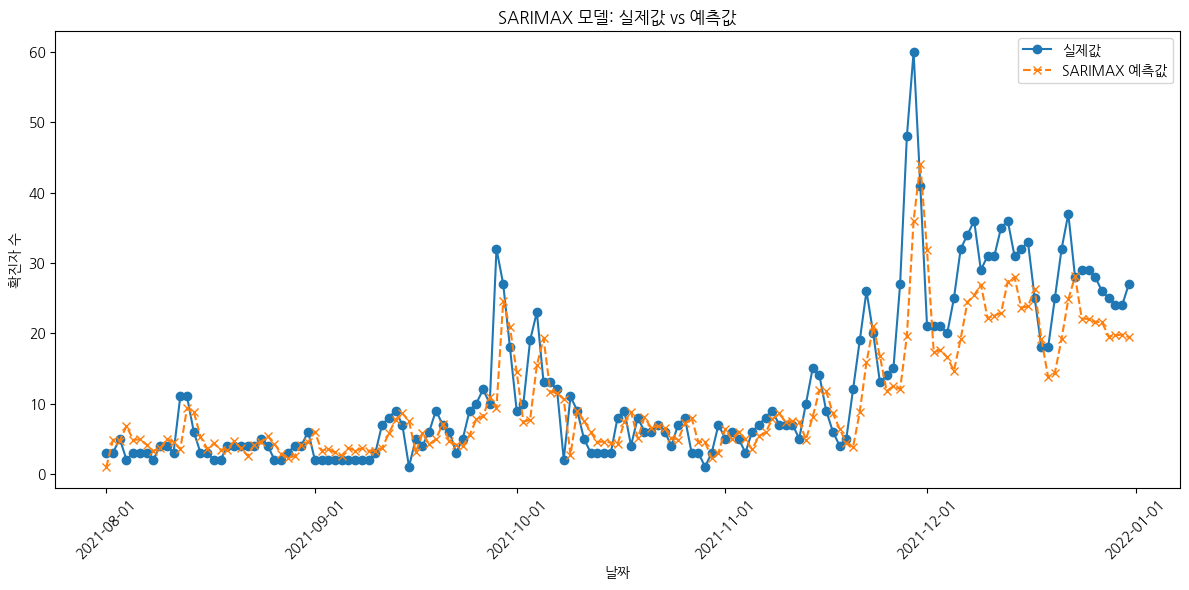

In [83]:
plot_actual_vs_predicted(test_df['Date'], y_test, sarimax_pred, "SARIMAX")


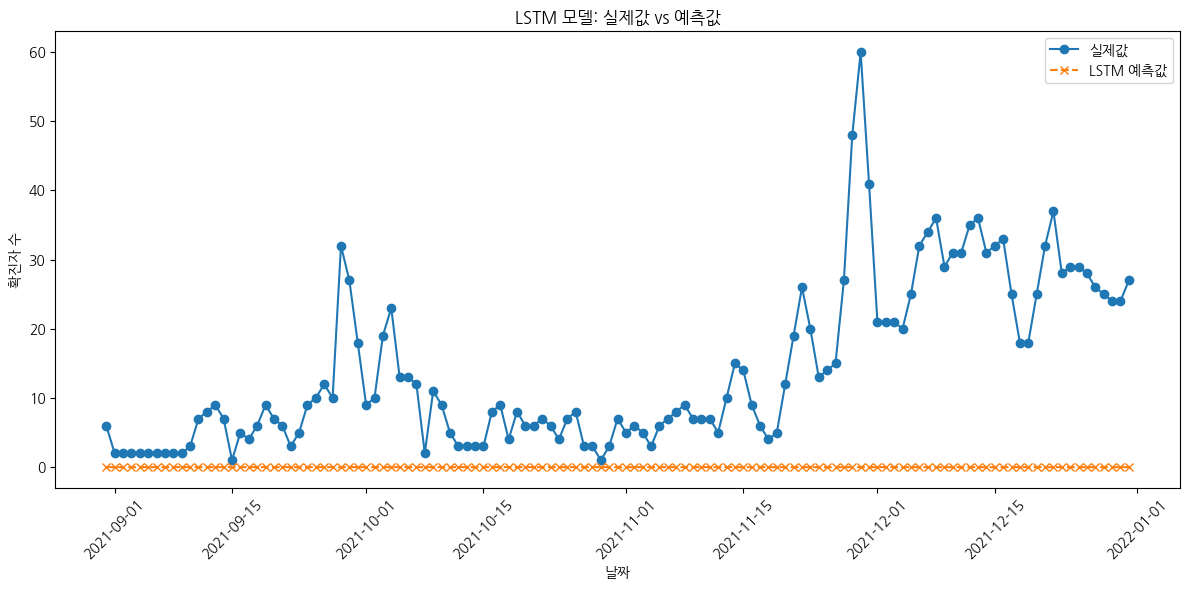

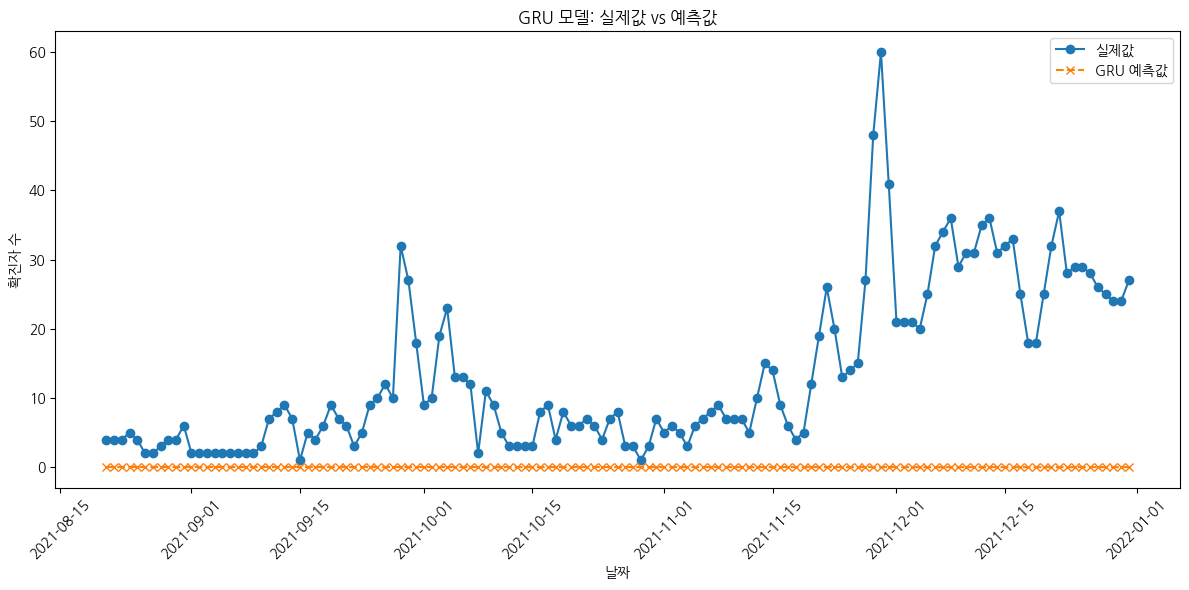

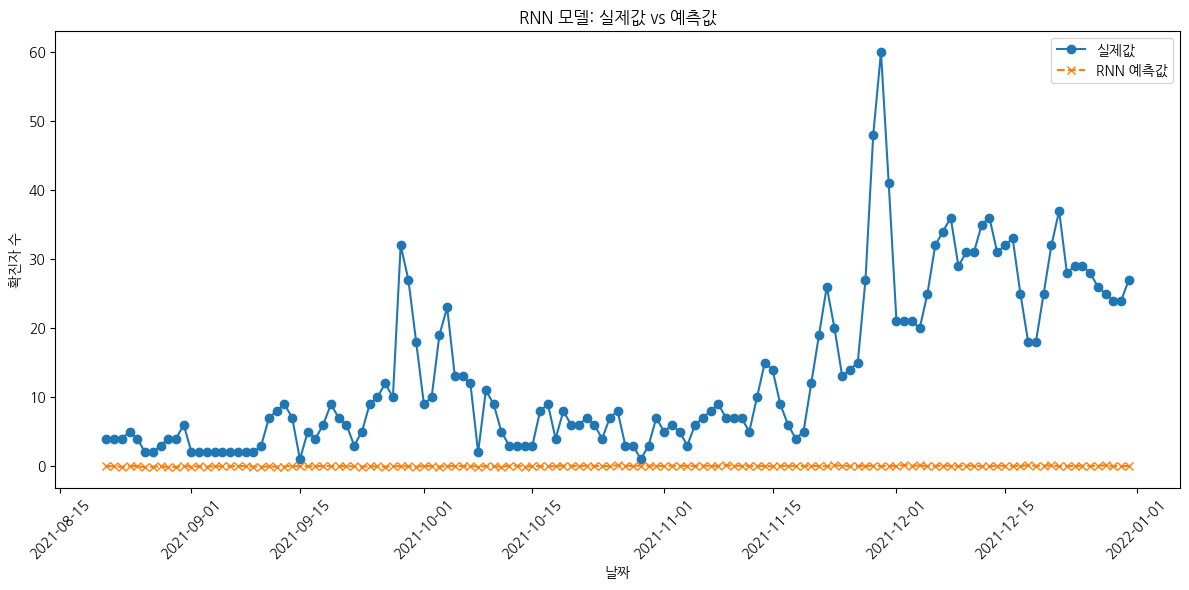

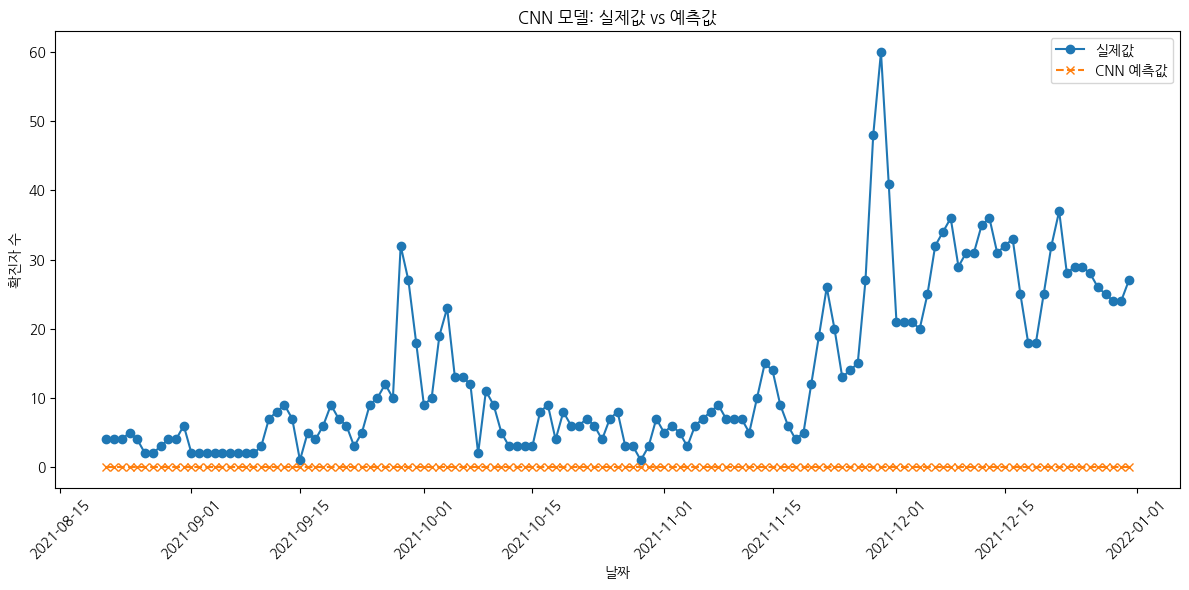

NameError: name 'svr_pred_opt' is not defined

In [84]:
# LSTM 모델
plot_actual_vs_predicted(test_df['Date'], y_test, lstm_pred, "LSTM")

# GRU 모델
plot_actual_vs_predicted(test_df['Date'], y_test, gru_pred, "GRU")

# RNN 모델
plot_actual_vs_predicted(test_df['Date'], y_test, rnn_pred, "RNN")

# CNN 모델
plot_actual_vs_predicted(test_df['Date'], y_test, cnn_pred, "CNN")

# SVM (SVR) 최적화 모델
plot_actual_vs_predicted(test_df['Date'], y_test, svr_pred_opt, "SVM(SVR)_Optuna")

# Random Forest 최적화 모델
plot_actual_vs_predicted(test_df['Date'], y_test, rf_pred_opt, "RF_Optuna")

# XGBoost 최적화 모델
plot_actual_vs_predicted(test_df['Date'], y_test, xgb_pred_opt, "XGBoost_Optuna")

# Prophet 모델
plot_actual_vs_predicted(test_df['Date'], y_test, prophet_pred, "Prophet")


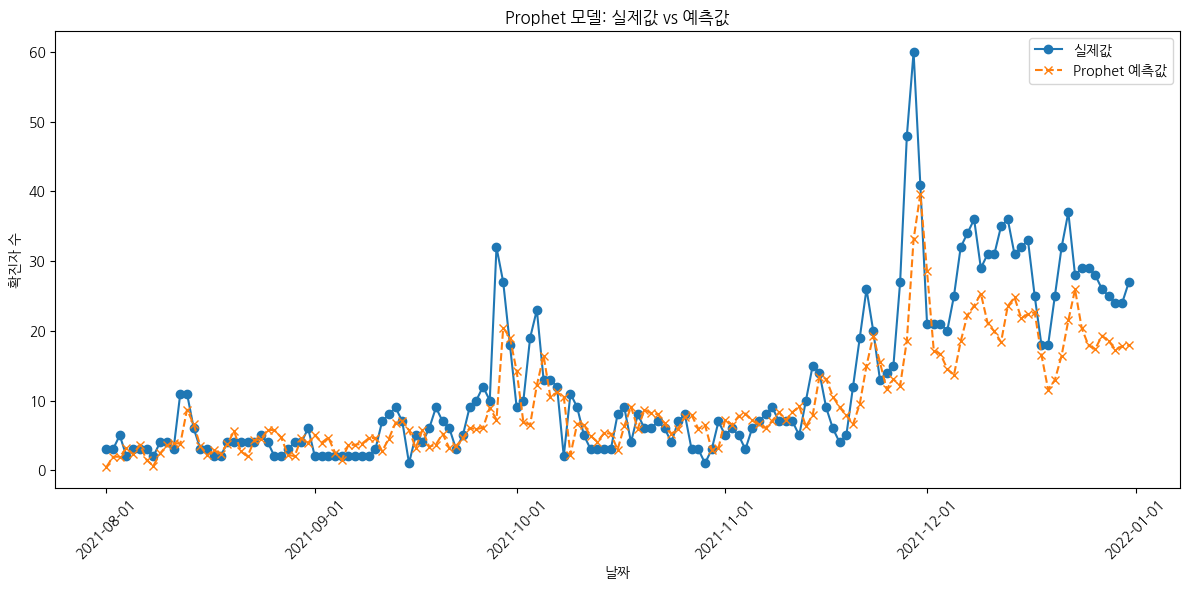